# 계산을 위한 Code

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import brute
import pyupbit
from datetime import datetime
import time
from dateutil.relativedelta import relativedelta
import warnings
from typing import *
import pandas_ta as ta
import talib
import empyrical as ep
from tqdm import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import joblib

In [110]:
class Action:
    """
    Abstract class for Order, OrderCancellation
    """
    def __init__(self):
        pass
class Strategy:
    """
    Abstract method for generating user-defined trading strategies with certis
    """
#     def __init__(self, config, name="CertisStrategy"):
#         self.config = config
#         self.name = name

    def calculate(self, data):
        return data

#     def calculate(self, data: pd.DataFrame):
#         return self._calculate(data)

#     def execute(self, state_dict: Dict[str, Any]) -> List[Action]:
#         raise NotImplementedError
def _power10(x):
    return np.power(10,x)
def _sma(series, n):
    return series.rolling(n).mean()
def cal_ma(data, method = 'sma', length=5):
    if method == 'sma':
        ma_result = ta.sma(data, length=length, talib=False)
    elif method == 'ema':
        ma_result = ta.ema(data, length=length, talib=False)
    elif method == 'wma':
        ma_result = ta.wma(data, length=length, talib=False)
    else:
        raise ValueError('Check ma method')
    return ma_result

In [121]:
class Backtest():
    def __init__(self, datetime_start, datetime_end, code_coin):
        self.data_hr = define_data(datetime_start-relativedelta(days=10), datetime_end, code_coin, timeframe='hourly')
        self.data_d = self.data_hr[['close']].resample('24H', origin=self.data_hr.index[0]).apply({'close':'last'})
        self.data_d['return'] = np.log10(self.data_d['close'] / self.data_d['close'].shift(1))
        self.data_d = self.data_d[['return']].loc[datetime_start:datetime_end]
        self.trading_fee = 0.1
        
    def cal_strategy(self, name, strategy_cls:type, strategy_list:None):
        self.strategy_list = strategy_list
        self.strategy : Strategy = strategy_cls(self.data_d, self.data_hr, name, self.strategy_list, self.trading_fee)
        self.data_d, self.data_hr = self.strategy.calculate()
#         self.test_result = self.strategy.calculate()  # finish_daily : 일별로 거래 종료되어 position이 거래횟수

    def analyze_result(self):
        return _analyze_result(self.data_d)

    def plot_results(self, markup=False):
        data = self.results.copy()
        _plot_results(data, markup)


In [82]:
def _analyze_result(data):
    name_list = ['name',"number_of_trading" , "number_of_trading_positive", "hit_ratio", "gain_loss_ratio", "expactacy_per_trade",
             "average_gain", "average_loss","total_profit", "cagr", "mdd", "std", "sharpe_ratio"]
    df_analysis = pd.DataFrame(index=range(len(data.columns)),columns=name_list)
    for i in range(len(data.columns)):
        col_name = data.columns[i]
        data_temp = data[col_name]
        df_analysis.iloc[i] = [col_name]+_analyze_result_ind2(data_temp)+_analyze_result_cont2(data_temp)
#         df_analysis = df_analysis.append([[col_name]+_analyze_result_ind2(data_temp)+_analyze_result_cont2(data_temp)],ignore_index=True)
    return df_analysis

In [125]:
def _plot_results(data, markup):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,6))
    fig, ax1 = plt.subplots()
    ax1.plot(data[['creturns', 'cstrategy']], label=['creturns', 'cstrategy'])
#     ax2 = ax1.twinx()
#     ax2.plot(data[['sma_short','sma_mid','sma_long']], label=['sma_short','sma_mid','sma_long'])
#     plt.plot(data[['creturns', 'cstrategy']], label=['creturns', 'cstrategy'])
#     plt.plot(data[['creturns', 'cstrategy','sma_short','sma_mid','sma_long']], label=['creturns', 'cstrategy','sma_short','sma_mid','sma_long'])
    plt.legend()
    if markup:
        signal_buy = np.where(data.buy_entry > data.buy_entry.shift(1) , 1, 0)
        signal_sell = np.where(data.buy_exit > data.buy_exit.shift(1), 1, 0)
        date_buy = list(data[signal_buy==1].index)
        date_sell = list(data[signal_sell==1].index)
        if len(date_buy)==0:
            raise ValueError('거래가 발생하지 않음.')
        if len(date_sell)+1 == len(date_buy):
            date_sell.append(data.index[-1])
        if date_sell[0] < date_buy[0]:
            date_sell = date_sell[1:]
        for date_start, date_end in zip(date_buy, date_sell):
            plt.axvspan(date_start, date_end, facecolor='gray', alpha=0.5)
    plt.show() 
def _analyze_result_ind2(data):
    number_of_trading = data[data != 0].count()
    number_of_trading_positive = data[data > 0].count()
    hit_ratio = number_of_trading_positive / number_of_trading
    average_gain = _power10(data[data > 0].mean())-1
    average_loss = _power10(data[data < 0].mean())-1
    expactacy_per_trade = _power10(data[data != 0].mean())-1
    analysis_ind = [number_of_trading , number_of_trading_positive, round(hit_ratio,2), round(-average_gain/average_loss,2), round(expactacy_per_trade*100,2), round(average_gain*100,2), round(average_loss*100,2)]
    return analysis_ind  
def _analyze_result_ind(data):
    # list_trading_period, list_trading_profit 계산
    list_trading_period = []
    list_trading_profit = []
    return_adj_temp = np.nan
    for return_adj,buy_entry,buy_exit in zip(data.strategy_return,data.buy_entry,data.buy_exit):
        if (buy_entry==1)&(buy_exit==1):
            list_trading_period.append(1)
            list_trading_profit.append(_power10(return_adj))
        elif (buy_entry==1)&(buy_exit==0):
            return_adj_temp = return_adj
            trading_period_temp = 1
        elif (buy_entry==0)&(buy_exit==0):
            if np.isnan(return_adj_temp):
                continue
            else:
                return_adj_temp += return_adj
                trading_period_temp += 1
        elif (buy_entry==0)&(buy_exit==1):
            return_adj_temp += return_adj
            trading_period_temp += 1
            list_trading_period.append(trading_period_temp)
            list_trading_profit.append(_power10(return_adj_temp))
        else:
            print("Check Data")
            raise ValueError
#     return list_trading_period, list_trading_profit 
    # 잔여 항목 계산
    array_trading_period = np.array(list_trading_period)
    array_trading_profit = np.array(list_trading_profit)
    number_of_trading = len(array_trading_period)
    array_trading_profit_positive = array_trading_profit[array_trading_profit>1]
    array_trading_profit_negative = array_trading_profit[array_trading_profit<=1]
    number_of_trading_positive = len(array_trading_profit_positive)
    number_of_trading_negative = len(array_trading_profit_negative)
    hit_ratio = number_of_trading_positive / number_of_trading
    expactacy_per_trade = (array_trading_profit_positive.sum()+array_trading_profit_negative.sum())/number_of_trading-1
    average_gain = array_trading_profit_positive.mean()-1
    average_loss = array_trading_profit_negative.mean()-1
    largest_gain = array_trading_profit_positive.max()-1
    largest_loss = array_trading_profit_negative.min()-1
    analysis_ind = [number_of_trading , number_of_trading_positive, round(hit_ratio,2), round(-average_gain/average_loss,2), round(expactacy_per_trade*100,2), round(average_gain*100,2), round(average_loss*100,2)]
    return analysis_ind
def _analyze_result_cont2(data):
    trade_year = (len(data)) / 365
    total_profit = _power10(data.cumsum().iloc[-1]) #본전이면 1
    cagr = (total_profit ** (1 / trade_year) - 1) # 본전이면 0
    mdd = ep.max_drawdown(data.apply(_power10)-1)
    std = data.dropna().std() * (365 ** 0.5)
    risk_free_rate = 0
    sharpe_ratio = (cagr - risk_free_rate) / std
    analysis_cont = [round(total_profit*100-100,2), round(cagr*100,2), round(mdd*100,2), round(std*100,2), round(sharpe_ratio,2)]
#     print(f"--------------------\n전체 수익 : {total_profit*100:.2f} ( {cagr:.2f} )\nMDD : {mdd:.2f}\nSTD : {std:.2f}\nSharpe Ratio : {sharpe_ratio:.2f}")
    return analysis_cont 
def _analyze_result_cont(data : pd.DataFrame = pd.DataFrame()):
    trade_year = (list(data.index)[-1] - list(data.index)[0]).days / 365
    
    total_profit = _power10(data.cstrategy.iloc[-1]) #본전이면 1
#     print(total_profit, trade_year)
    cagr = (total_profit ** (1 / trade_year) - 1) # 본전이면 0
    mdd = ep.max_drawdown(data.strategy.apply(_power10)-1)
    
    std = data.strategy.dropna().std() * (365 ** 0.5)
    
    risk_free_rate = 0
    sharpe_ratio = (cagr - risk_free_rate) / std
    
    analysis_cont = [round(total_profit*100-100,2), round(cagr*100,2), round(mdd*100,2), round(std*100,2), round(sharpe_ratio,2)]
#     print(f"--------------------\n전체 수익 : {total_profit*100:.2f} ( {cagr:.2f} )\nMDD : {mdd:.2f}\nSTD : {std:.2f}\nSharpe Ratio : {sharpe_ratio:.2f}")
    return analysis_cont 
def _analyze_result_per(data):
    # list_trading_period, list_trading_profit 계산
    list_trading_period = [] # 몇 거래일동안 거래하는지
    list_trading_date_start = []  # 거래시작일
    list_trading_date_end = []  # 거래종료일
    list_trading_profit = []  #거래 당 수익률
    return_adj_temp = np.nan
    for return_adj,buy_entry,buy_exit,date in zip(data.strategy_return,data.buy_entry,data.buy_exit,data.index):
        if (buy_entry==1)&(buy_exit==1):
            list_trading_period.append(1)
            list_trading_date_start.append(date)
            list_trading_date_end.append(date)
            list_trading_profit.append(_power10(return_adj))
        elif (buy_entry==1)&(buy_exit==0):
            list_trading_date_start.append(date)
            return_adj_temp = return_adj
            trading_period_temp = 1
        elif (buy_entry==0)&(buy_exit==0):
            if np.isnan(return_adj_temp):
                continue
            else:
                return_adj_temp += return_adj
                trading_period_temp += 1
        elif (buy_entry==0)&(buy_exit==1):
            list_trading_date_end.append(date)
            return_adj_temp += return_adj
            trading_period_temp += 1
            list_trading_period.append(trading_period_temp)
            list_trading_profit.append(_power10(return_adj_temp))
        else:
            print("Check Data")
            raise ValueError
   
    df_trading_ind = pd.DataFrame(columns = ['trading_no','profit'], index =  list_trading_date_start)
    df_trading_ind['trading_no'] = list_trading_period
    df_trading_ind['profit'] = np.array(list_trading_profit)-1
    
    df_trading_ind_month = df_trading_ind.resample('M').apply({'trading_no':'sum','profit':'sum'})
  
    return df_trading_ind_month
def _plot_analysis_per(data):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,6))
    fig, ax1 = plt.subplots()
    ax1.plot(data['trading_no'], color = 'red')
    ax1.set_ylabel('trading_no', color = 'red', rotation = 90)
    ax1.set_ylim(0, 30)
    ax2 = ax1.twinx()
    ax2.plot(data['profit'], color = 'blue')
    ax2.set_ylabel('profit', color = 'blue', rotation = 90)
    # ax2.set_ylim(-1, 1)
#     plt.legend()
    plt.show()
def _delete_log_result():
    if 'dict_log_result' in globals():
        global dict_log_result 
        del dict_log_result
        print("log 삭제 완료")
    else:
        print("log가 존재하지 않음")
def _add_log_result(*informations):
    if not 'dict_log_result' in globals():
        global dict_log_result 
        dict_log_result = {}
#         pass
    result_temp = []
    for information in informations:
        result_temp += information
    dict_log_result[f'case {len(dict_log_result)+1}'] = result_temp
    return dict_log_result
def _return_log_result(log_result=None):
    if not 'dict_log_result' in globals():
        print('log가 존재하지 않음')
    else:
        global dict_log_result
        name_list = ['name',"number_of_trading" , "number_of_trading_positive", "hit_ratio", "gain_loss_ratio", "expactacy_per_trade",
             "average_gain", "average_loss","total_profit", "cagr", "mdd", "std", "sharpe_ratio"]
        df = pd.DataFrame(dict_log_result,index=name_list).T
        number_of_trading_allCoin = int(df.number_of_trading.sum())
        number_of_trading_positive_allCoin = df.number_of_trading_positive.sum()
        number_of_trading_negative_allCoin = number_of_trading_allCoin - number_of_trading_positive_allCoin
        hit_ratio_allCoin = number_of_trading_positive_allCoin / number_of_trading_allCoin
        average_gain_allCoin = (df.number_of_trading_positive * df.average_gain).sum() / number_of_trading_positive_allCoin
        average_loss_allCoin = ((df.number_of_trading - df.number_of_trading_positive) * df.average_loss).sum() / (number_of_trading_negative_allCoin)
        expactacy_per_trade_allCoin = (average_gain_allCoin*number_of_trading_positive_allCoin + average_loss_allCoin*number_of_trading_negative_allCoin) / number_of_trading_allCoin
        gain_loss_ratio_allCoin = -average_gain_allCoin / average_loss_allCoin
#         print("----------결과분석----------")
        print(f'--------------------\n거래횟수 (상승) : {number_of_trading_allCoin} ( {number_of_trading_positive_allCoin} )\n승률 : {hit_ratio_allCoin:.2f}\n손익비 : {-average_gain_allCoin/average_loss_allCoin:.2f}\n거래 당 기대수익률 (상승/하락) : {expactacy_per_trade_allCoin:.2f} ( {average_gain_allCoin:.2f} / {average_loss_allCoin:.2f} )')

In [112]:
date_start = datetime(2017,11,1,9)
date_end = datetime(2022,10,10)
# date_end = datetime(2022,3,31)
code_coin = 'KRW-BTC'

def define_data ( start , end , code, timeframe = 'daily', time_start = 9 ) :
    if timeframe == 'daily':
        if time_start == 9:
            data_all = pd.read_pickle("./data/data_coin_daily.pkl")
            data_all = data_all[data_all.coin == code]
            data_all = data_all[(data_all.date >= start)&(data_all.date <= end)]
        else:
            data_hourly = pd.read_pickle('./data/data_coin_hourly.pkl')
            data_hourly = data_hourly[data_hourly.coin == code]
            start_datetime = start.replace(hour=time_start)
            data_hourly = data_hourly[data_hourly.date >= start_datetime]
            data_hourly.index = data_hourly.date
            dict_ohlcv = {'open':'first','high':'max','low':'min','close':'last','value':'sum','volume':'sum','date':'first'}
            data_all = data_hourly.resample('24H',origin=start_datetime).apply(dict_ohlcv)
            data_all = data_all[(data_all.date >= start)&(data_all.date <= end)]
    elif timeframe == 'hourly':
        data_all = pd.read_pickle('./data/data_coin_hourly.pkl')
        data_all = data_all[data_all.coin == code]
        data_all = data_all[(data_all.date >= start)&(data_all.date <= end)]
    else:
        print("Timeframe 확인")
    data_all['return'] = np.log10(data_all.close / data_all.close.shift(1))
#     data_all.reset_index(drop=True, inplace=True)
    data_all.index = data_all.date
    data_all.index.name = None
    data_all['open'] = data_all['close'].shift(1)
    return data_all[['open','high','low','close','volume','value']]

data_raw = define_data(date_start,date_end,code_coin,'daily')
data_raw_hourly = define_data(date_start,date_end,code_coin,'hourly')

In [134]:
class Strategy_Volatility_new(Strategy):
    def __init__(self, data_d, data_hr, name, strategy_list=['base'], trading_fee=0.1):
        self.data_d = data_d
        self.data_hr = data_hr
        self.name = name
        self.strategy_list = strategy_list
        self.trading_fee = trading_fee
        
    def calculate_volatility_breakout(self):
        data_raw = self.data_hr
        data_raw = self.input_signal_volatility(data_raw)
        data_raw = self.input_status(data_raw)
        self.data_hr = data_raw.copy()
        data_d = self.cal_daily_return(data_raw,self.trading_fee)
        self.data_d[self.name] = data_d
        return data_raw
        
    def calculate_volatility_breakout_stoploss(self):
        data_raw = self.data_hr
        data_raw = self.input_signal_volatility(data_raw)
        data_raw = self.input_stoploss(data_raw)
#         data_raw = self.input_takeprofit(data_raw)
        data_raw = self.input_status(data_raw)
        self.data_hr = data_raw.copy()
        data_d = self.cal_daily_return(data_raw,self.trading_fee)
        self.data_d[self.name] = data_d
        return data_raw
    
    def calculate_volatility_breakout_takeprofit(self):
        data_raw = self.data_hr
        data_raw = self.input_signal_volatility(data_raw)
#         data_raw = self.input_stoploss(data_raw)
        data_raw = self.input_takeprofit(data_raw)
        data_raw = self.input_status(data_raw)
        self.data_hr = data_raw.copy()
        data_d = self.cal_daily_return(data_raw,self.trading_fee)
        self.data_d[self.name] = data_d
        return data_raw    

    # data_raw에 전략 signal넣기
    def input_signal_volatility(self, data):
        start_hour = 9
        data_hr = data
        data_hr.index.name = None
        start_datetime = data_hr.index[0].replace(hour=start_hour)
        data_hr = data_hr.loc[start_datetime:]
        dict_ohlcv = {'open':'first','high':'max','low':'min','close':'last','value':'sum'}
        data_period = data_hr.resample('24H', origin=start_datetime ).apply(dict_ohlcv).loc[start_datetime:]
        # start 넣기
        data_period['start'] = 1
        # target_price 넣기
        price_range = data_period['high']-data_period['low']
        k_value = np.maximum( 0.5, ( abs( data_period.open.shift(1) - data_period.close.shift(1) ) / price_range.shift(1) ))
#         k_value = 0.5
        buy_price = data_period['open'] + price_range.shift(1) * k_value
        data_period['buy_price'] = buy_price
        data_period['gap_price'] = price_range.shift(1) * k_value

        # 시간별 자료에 넣기
        data_hr['start'] = data_period['start']
        data_hr['buy_price'] = data_period['buy_price']  #9시에 들어감.
        data_hr['buy_price'].fillna(method='ffill', inplace=True)
        data_hr['gap_price'] = data_period['gap_price']  #9시에 들어감.
        data_hr['gap_price'].fillna(method='ffill', inplace=True)

       # signal 넣기
        data_hr['signal'] = np.where(data_hr['high'] > data_hr['buy_price'], 1, np.where(data_hr['start']==1, 0, np.nan))
        data_hr['signal_fill'] = data_hr['signal'].fillna(method='ffill')
        # 수익률적용위해 매수시점의 수익률은 open_adj로 입력
        data_hr['open_adj'] = np.where( (data_hr['signal_fill']==1)&(data_hr['signal_fill'].shift(1)==0), data_hr['buy_price'], data_hr['open'] )
        return data_hr

    # data_raw에 SL / TP 기입 low<sl_price
    def input_stoploss(self, data):
        data_hr = data
        start_hour = data_hr.index[0].hour
        data_hr['date'] = [day.strftime('%y%m%d') for day in data_hr.index]
        data_hr['date'] = data_hr['date'].shift(start_hour)

        # 시간대별 rolling max를 계산한 뒤 low가 이보다 작으면 low에 매도되는걸로 수익률 계산.
        data_hr['CM_price'] = data_hr[['date','high']].groupby(by='date').cummax()  #일별 누적맥스
        data_hr['CM_price'].fillna(0,inplace=True)
        data_hr['SL_price'] = data_hr['CM_price']*(1-0.05)  # 5%하락시 매도
        data_hr['SL_signal'] = np.where( data_hr['low'] < data_hr['SL_price'], 1, np.nan)

        # 수정 종가 기입
        if 'close_adj' not in data_hr.columns:
            data_hr['close_adj'] = data_hr['close']
        data_hr['close_adj'] = np.where(data_hr['SL_signal']==1, data_hr['SL_price'], data_hr['close_adj'])
        return data_hr

    def input_takeprofit(self, data):
        data_hr = data

        data_hr['TP_price'] = data_hr['buy_price'] + data_hr['gap_price']  # buy_price만큼 더 상승시 익절.
        data_hr['TP_signal'] = np.where( data_hr['high'] > data_hr['TP_price'], 1, np.nan)

        # 수정 종가 기입
        if 'close_adj' not in data_hr.columns:
            data_hr['close_adj'] = data_hr['close']
        data_hr['close_adj'] = np.where(data_hr['TP_signal']==1, data_hr['TP_price'], data_hr['close_adj'])
        return data_hr

    # data_raw에 status 기입
    def input_status(self, data):
        data_hr = data
        data_hr['status'] = np.nan
        if 'SL_signal' in data_hr.columns:
            data_hr['status'] = np.where(data_hr['SL_signal'].shift(1)==1, 0, data_hr['status'])
        if 'TP_signal' in data_hr.columns:
            data_hr['status'] = np.where(data_hr['TP_signal'].shift(1)==1, 0, data_hr['status'])
        data_hr['status'] = np.where(data_hr['signal'].notna(), data_hr['signal'], data_hr['status'])
        data_hr['status_fill'] = data_hr['status'].fillna(method='ffill')
        return data_hr

    # data_raw를 일별 return으로 변환하기.
    def cal_daily_return(self, data, trading_fee):
        data_hr = data
        if 'close_adj' not in data_hr.columns:
            data_hr['close_adj'] = data_hr['close']
        data_hr['return'] = np.log10(data_hr.close / data_hr.open)
        data_hr['strategy_return'] = np.log10(data_hr.close_adj / data_hr.open_adj)*data_hr['status_fill']
        dict_ohlcv = {'return':'sum','strategy_return':'sum'}
        data_d = data_hr[['return','strategy_return']].resample('24H', origin=data_hr.index[0]).apply(dict_ohlcv)
        buy_entry = np.where(data_d.strategy_return == 0, 0, 1)
        data_d['buy_entry'] = buy_entry
        data_d['buy_exit'] = buy_entry
        if (data_d.buy_entry.sum() == 0) & (data_d.buy_exit.sum() == 0):
            raise ValueError('Buy_Entry, Buy_Exit 가 없음')
        # 수수료 반영
        if not self.trading_fee == 0:
            data_d['strategy_return'] = data_d['strategy_return'] + data_d['buy_entry'] * np.log10(1-(trading_fee*0.01))
            data_d['strategy_return'] = data_d['strategy_return'] + data_d['buy_exit'] * np.log10(1-(trading_fee*0.01))

        return data_d['strategy_return']      


    def apply_price_noise_filter(self, noise_value = 0.2):
        data_raw_temp = self.data_raw.copy()
        noise = cal_ma((data_raw_temp.high-data_raw_temp.close)/(data_raw_temp.high - data_raw_temp.low),method='sma',length=5)
        data_raw_temp.buy_entry = np.where(noise.shift(1)<noise_value,data_raw_temp.buy_entry, 0)
        data_raw_temp.buy_exit = data_raw_temp.buy_entry
        data_raw_temp.strategy_return = np.where(data_raw_temp.buy_entry,data_raw_temp.strategy_return,0)
        self.data_raw = data_raw_temp
    def apply_volume_filter(self, target_volume = 100000000000):
        data_raw_temp = self.data_raw.copy()
#         volume_filter = (data_raw_temp.value > 10**11) # 매수할 수 있으면 True
        volume_filter = (data_raw_temp.value > target_volume) # 매수할 수 있으면 True
        data_raw_temp.buy_entry = np.where(volume_filter.shift(1), data_raw_temp.buy_entry, 0)
        data_raw_temp.buy_exit = data_raw_temp.buy_entry
        data_raw_temp.strategy_return = np.where(data_raw_temp.buy_entry,data_raw_temp.strategy_return,0)
        self.data_raw = data_raw_temp
    def apply_volume_trend_filter(self, method = 'sma', length = 5):
        data_raw_temp = self.data_raw.copy()
#         volume_trend_filter = (data_raw_temp['volume'] > ta.sma(data_raw_temp['volume'], length=5, talib=False))
        volume_trend_filter = (data_raw_temp['volume'] > cal_ma(data_raw_temp['volume'], method=method, length=length))
        
        data_raw_temp.buy_entry = np.where(volume_trend_filter.shift(1), data_raw_temp.buy_entry, 0)
        data_raw_temp.buy_exit = data_raw_temp.buy_entry
        data_raw_temp.strategy_return = np.where(data_raw_temp.buy_entry,data_raw_temp.strategy_return,0)
        self.data_raw = data_raw_temp
    def apply_price_trend_filter(self, method = 'sma', length = 5):
        data_raw_temp = self.data_raw.copy()
        price_trend_filter = (data_raw_temp['close'] > cal_ma(data_raw_temp['close'], method=method, length=length)*0.95)
        data_raw_temp.buy_entry = np.where(price_trend_filter.shift(1), data_raw_temp.buy_entry, 0)
        data_raw_temp.buy_exit = data_raw_temp.buy_entry
        data_raw_temp.strategy_return = np.where(data_raw_temp.buy_entry,data_raw_temp.strategy_return,0)
        self.data_raw = data_raw_temp
        
    def calculate(self):
        for strategy in self.strategy_list:
            if 'base' in strategy:
                self.calculate_volatility_breakout()
            elif 'stoploss' in strategy:
                self.calculate_volatility_breakout_stoploss()
            elif 'takeprofit' in strategy:
                self.calculate_volatility_breakout_takeprofit()
            elif 'filter' in strategy:
                if 'volume_filter' in strategy:
                    if len(strategy.split(', ')) == 1:
                        self.apply_volume_filter()
                    else:
                        _, target_volume = strategy.split(', ')
                        self.apply_volume_filter(int(target_volume))
                elif 'volume_trend_filter' in strategy:
                    if len(strategy.split(', ')) == 1:
                        self.apply_volume_trend_filter()
                    else:
                        _, method, length = strategy.split(', ')
                        self.apply_volume_trend_filter(method, int(length))
                elif 'price_trend_filter' in strategy:
                    if len(strategy.split(', ')) == 1:
                        self.apply_price_trend_filter()
                    else:
                        _, method, length = strategy.split(', ')
                        self.apply_price_trend_filter(method, int(length))
                elif "price_noise_filter" in strategy:
                    if len(strategy.split(', ')) == 1:
                        self.apply_price_noise_filter()
                    else:
                        _, noise_value = strategy.split(', ')
                        self.apply_price_noise_filter(float(noise_value))
            elif strategy == 'None':
                continue
            else:
                raise ValueError('Strategy Name 확인 필요')
#         return self.data_raw[['open','close','high','low','target_price','stoploss','strategy_return','return','buy_entry','buy_exit']]        
        return self.data_d, self.data_hr

## ML

In [25]:
# variable 생성 함수 공통으로 사용.

def make_ml_dataset(data_raw):
    data_raw['target'] = np.where(data_raw['return'] > np.log10(1), 1, 0)

    data_raw['rtn_l1'] = data_raw['return'].rolling(5).sum().shift(1)
    data_raw['rtn_l2'] = data_raw['return'].rolling(20).sum().shift(1)
    data_raw['rtn_l3'] = data_raw['return'].rolling(60).sum().shift(1)

    data_raw['u_noise'] = 1- np.abs(data_raw['high']-data_raw['close'])/(data_raw['high']-data_raw['low'])
    data_raw['d_noise'] = 1- np.abs(data_raw['close']-data_raw['low'])/(data_raw['high']-data_raw['low'])

    data_raw['u_noise_l1'] = data_raw['u_noise'].rolling(5).mean().shift(1)
    data_raw['d_noise_l1'] = data_raw['d_noise'].rolling(5).mean().shift(1)

    data_raw['value_cng'] = data_raw['value'].pct_change()
    data_raw['value_cng_l1'] = data_raw['value_cng'].rolling(5).mean().shift(1)

    data_raw.dropna(inplace=True)
    ml_dataset = data_raw[['rtn_l1', 'rtn_l2', 'rtn_l3', 'u_noise_l1', 'd_noise_l1','value_cng_l1']].to_numpy()
    target = data_raw['target'].to_numpy()
    return ml_dataset, target

In [27]:
model = joblib.load('./model/model2.pkl')
# score = loaded_model.score(X,y)

def calculate_ml(data_raw, model):
    start_hour = 9

    data_raw_hourly_temp = data_raw.copy()
    data_raw_hourly_temp.index.name = None
    start_datetime = data_raw_hourly_temp.index[0].replace(hour=start_hour)
    data_raw_hourly_temp = data_raw_hourly_temp.loc[start_datetime:]
    # 일별 자료로 변환한 후 target_price계산.
    dict_ohlcv = {'open':'first','high':'max','low':'min','close':'last','value':'sum','return':'sum'}
    data_raw_temp = data_raw_hourly_temp.resample('24H', origin=start_datetime ).apply(dict_ohlcv).loc[start_datetime:]

    input_data, _ = make_ml_dataset(data_raw_temp)
    buy_entry = model.predict(input_data)

    data_raw_temp = data_raw_temp.iloc[-len(buy_entry):]

    data_raw_temp['buy_entry'] = buy_entry
    data_raw_temp['buy_exit'] = buy_entry

    data_raw_temp['strategy_return'] = np.where(data_raw_temp.buy_entry == 1, data_raw_temp['return'], 0)

    data_raw = data_raw_temp[['return','strategy_return','buy_entry','buy_exit']]
    return data_raw
#     return input_data

In [7]:
date_start = datetime(2017,10,1)
# date_start = datetime(2022,1,1)
date_end = datetime(2022,8,31)
coin_code = 'KRW-BTC'
data_raw = define_data(date_start-relativedelta(days=10),date_end,coin_code,time_start=9,timeframe='hourly')
# case1 = Backtest(data_raw, Strategy_Volatility, strategy_list=['ml'])


In [71]:
case1.trading_fee = 0.1
case1.cal_strategy()
case1.test_result = case1.test_result.loc[date_start:date_end]
case1.cal_result()
print(case1.analyze_result_cont())
print(case1.analyze_result_ind())

전체수익 : 54.01 %, CAGR : 128.24 %, MDD : -18.71 %, STD : 14.43 %, Sharpe : 8.89
거래횟수 (수익, 승률 ) : 85 ( 54, 0.64), 평균 수익률 % (수익, 손실, 손익비) : 0.54 (1.92, -1.86, 1.03)


## 상관관계

In [ ]:
data=pd.DataFrame()
data['return'] = np.log10(data_raw['close']/data_raw['open'])
data['l1'] = data['return'].shift(1)
data['l4'] = data['return'].rolling(4).mean().shift(1)
data['l12'] = data['return'].rolling(12).mean().shift(1)
data['l24'] = data['return'].rolling(24).mean().shift(1)
data['l48'] = data['return'].rolling(48).mean().shift(1)
data['r1'] = data['return']
data['r4'] = data['return'].rolling(4).mean().shift(-3)
data['r12'] = data['return'].rolling(12).mean().shift(-11)
data['r24'] = data['return'].rolling(24).mean().shift(-23)
data['r48'] = data['return'].rolling(48).mean().shift(-47)
data.corr()

# TEST

In [130]:
case1.data_hr

,open,high,low,close,volume,value,start,buy_price,gap_price,signal,signal_fill,open_adj,status,status_fill
2017-10-22 09:00:00,NaN,6988000.0,6858000.0,6938000.0,0.037948,2.617069e+05,1.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0
2017-10-22 10:00:00,6938000.0,7028000.0,6882000.0,6930000.0,0.036254,2.520525e+05,NaN,NaN,NaN,NaN,0.0,6938000.0,NaN,0.0
2017-10-22 11:00:00,6930000.0,6954000.0,6799000.0,6834000.0,0.078810,5.393456e+05,NaN,NaN,NaN,NaN,0.0,6930000.0,NaN,0.0
2017-10-22 12:00:00,6834000.0,6937000.0,6821000.0,6842000.0,0.089230,6.136175e+05,NaN,NaN,NaN,NaN,0.0,6834000.0,NaN,0.0
2017-10-22 13:00:00,6842000.0,6928000.0,6721000.0,6764000.0,0.036506,2.489630e+05,NaN,NaN,NaN,NaN,0.0,6842000.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 05:00:00,27520000.0,27639000.0,27383000.0,27503000.0,66.571133,1.832068e+09,NaN,28485000.0,693000.0,NaN,0.0,27520000.0,NaN,0.0
2022-08-31 06:00:00,27503000.0,27550000.0,27325000.0,27399000.0,95.711428,2.627977e+09,NaN,28485000.0,693000.0,NaN,0.0,27503000.0,NaN,0.0
2022-08-31 07:00:00,27399000.0,27404000.0,27259000.0,27401000.0,144.998889,3.962075e+09,NaN,28485000.0,693000.0,NaN,0.0,27399000.0,NaN,0.0
2022-08-31 08:00:00,27401000.0,27419000.0,27255000.0,27314000.0,128.538452,3.512976e+09,NaN,28485000.0,693000.0,NaN,0.0,27401000.0,NaN,0.0


In [135]:
date_start = datetime(2017,11,1,9)
date_end = datetime(2022,8,31,9)
coin_code = 'KRW-BTC'
case1 = Backtest(date_start,date_end,coin_code)
case1.cal_strategy('base', Strategy_Volatility_new,['base'])
case1.cal_strategy('SL', Strategy_Volatility_new,['stoploss'])
case1.cal_strategy('TP', Strategy_Volatility_new,['takeprofit'])
case1.analyze_result()

,name,number_of_trading,number_of_trading_positive,hit_ratio,gain_loss_ratio,expactacy_per_trade,average_gain,average_loss,total_profit,cagr,mdd,std,sharpe_ratio
0,return,1760,926,0.53,0.98,0.07,2.43,-2.48,269.91,31.06,-86.81,31.69,0.98
1,base,599,295,0.49,1.49,0.34,2.38,-1.59,669.72,52.51,-36.2,14.1,3.72
2,SL,599,281,0.47,1.51,0.27,2.48,-1.63,409.98,40.06,-38.73,16.23,2.47
3,TP,599,179,0.3,0.26,-4.03,1.63,-6.35,-100.0,-99.39,-100.0,67.1,-1.48


In [113]:
date_start = datetime(2017,11,1)
# # date_start = datetime(2022,1,1)
date_end = datetime(2022,8,31)
coin_code = 'KRW-BTC'
data_raw = define_data(date_start-relativedelta(days=10),date_end,coin_code,time_start=9,timeframe='hourly')
# case1 = Backtest(data_raw2, Strategy_Volatility, strategy_list=['stoploss'])
# case1.trading_fee = 0.1
# case1.cal_strategy()
# case1.test_result = case1.test_result.loc[date_start:date_end]
# case1.cal_result()
case2 = Backtest(data_raw2, Strategy_Volatility_new, strategy_list=['stoploss'])
case2.trading_fee = 0.1
# case2.cal_strategy()
# case2.test_result = case2.test_result.loc[date_start:date_end]
# case2.cal_result()

(0.57, 0.89)

In [114]:
case2.results

,strategy_return,return,buy_entry,buy_exit,strategy,creturns,cstrategy
2017-11-01 09:00:00,0.000000,0.021462,0,0,0.000000,0.021462,0.000000
2017-11-02 09:00:00,0.001410,0.022730,1,1,0.001410,0.044192,0.001410
2017-11-03 09:00:00,0.000000,-0.003929,0,0,0.000000,0.040263,0.001410
2017-11-04 09:00:00,-0.002738,0.010694,1,1,-0.002738,0.050957,-0.001329
2017-11-05 09:00:00,0.000000,0.005532,0,0,0.000000,0.056490,-0.001329
...,...,...,...,...,...,...,...
2022-08-26 09:00:00,-0.024485,-0.020191,1,1,-0.024485,0.576156,0.886375
2022-08-27 09:00:00,0.000000,-0.003586,0,0,0.000000,0.572570,0.886375
2022-08-28 09:00:00,0.000000,-0.010138,0,0,0.000000,0.562432,0.886375
2022-08-29 09:00:00,-0.000040,0.010967,1,1,-0.000040,0.573399,0.886335


In [102]:
case2.analyze_result_ind()

'거래횟수 (수익, 승률 ) : 681 ( 323, 0.47), 평균 수익률 % (수익, 손실, 손익비) : 0.39 (2.54, -1.56, 1.63)'

In [115]:
date_start1 = datetime(2017,11,1)
date_start2 = datetime(2022,1,1)
date_end1 = datetime(2021,12,31)
date_end2 = datetime(2022,8,31)
coin_code = 'KRW-ETH'
start_time = 9

# base 전략

for date_start, date_end in [(date_start1, date_end2), (date_start1, date_end1), (date_start2, date_end2)]:
    data_raw = define_data(date_start-relativedelta(days=10),date_end,coin_code,time_start=start_time,timeframe='hourly')

    case2 = Backtest(data_raw, Strategy_Volatility_new, strategy_list=[f'stoploss'])
    case2.trading_fee = 0.1
    case2.cal_strategy()
    case2.test_result = case2.test_result.loc[date_start:date_end]
    case2.cal_result()
    print(case2.analyze_result_cont())
    print(case2.analyze_result_ind())

전체수익 : 2793.97 %, CAGR : 100.71 %, MDD : -33.00 %, STD : 18.23 %, Sharpe : 5.52
거래횟수 (수익, 승률 ) : 626 ( 330, 0.53), 평균 수익률 % (수익, 손실, 손익비) : 0.61 (2.92, -1.97, 1.48)
전체수익 : 3263.68 %, CAGR : 132.61 %, MDD : -33.00 %, STD : 18.45 %, Sharpe : 7.19
거래횟수 (수익, 승률 ) : 540 ( 294, 0.54), 평균 수익률 % (수익, 손실, 손익비) : 0.72 (2.95, -1.94, 1.52)
전체수익 : -12.38 %, CAGR : -18.13 %, MDD : -25.67 %, STD : 16.81 %, Sharpe : -1.08
거래횟수 (수익, 승률 ) : 84 ( 35, 0.42), 평균 수익률 % (수익, 손실, 손익비) : -0.10 (2.78, -2.15, 1.29)


                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2004-06-01  2004-06-01
End Period          2022-08-10  2022-08-10
Risk-Free Rate      0.0%        0.0%
Time in Market      41.0%       99.0%

Cumulative Return   135.78%     315.3%
CAGR﹪              4.82%       8.14%

Sharpe              0.51        0.49
Prob. Sharpe Ratio  98.38%      98.09%
Sortino             0.72        0.69
Sortino/√2          0.51        0.49
Omega               1.15        1.15

Max Drawdown        -25.35%     -52.66%
Longest DD Days     2145        2142

Gain/Pain Ratio     0.15        0.1
Gain/Pain (1M)      0.52        0.52

Payoff Ratio        0.95        0.95
Profit Factor       1.15        1.1
Common Sense Ratio  1.28        1.04
CPC Index           0.6         0.56
Tail Ratio          1.11        0.95
Outlier Win Ratio   14.13       3.27
Outlier Loss Ratio  3.86        3.17

MTD                 0.23%       0.23%
3M                  0.06%       -5.86%

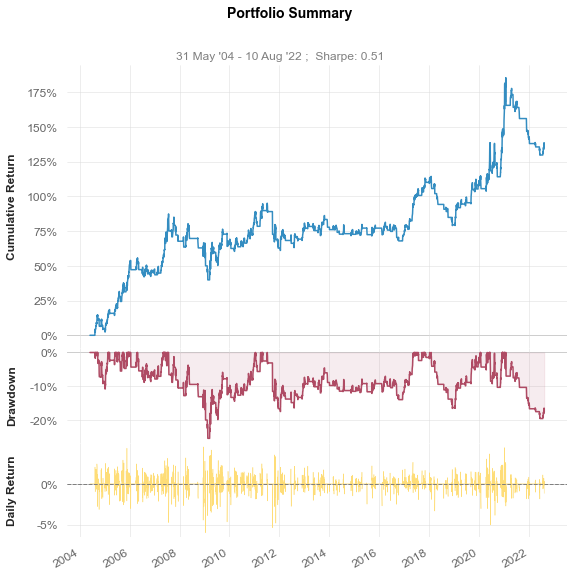

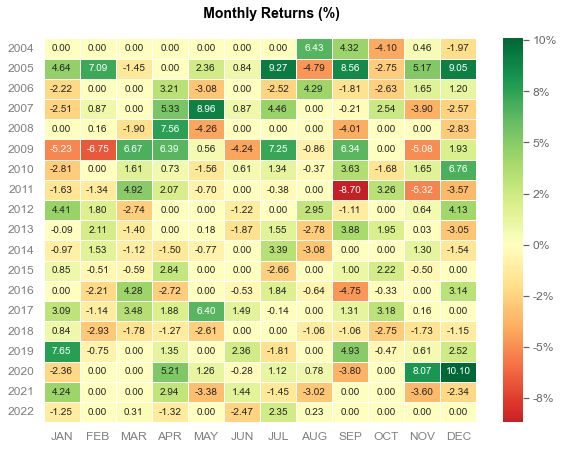

In [42]:
import quantstats as qs
qs.reports.basic(_power10(case1.test_result.strategy_return)-1,benchmark=df_stock.Change)

In [82]:
name_list = ['name',"number_of_trading" , "number_of_trading_positive", "hit_ratio", "gain_loss_ratio", "expactacy_per_trade",
             "average_gain", "average_loss","total_profit", "cagr", "mdd", "std", "sharpe_ratio"]
df1 = pd.DataFrame(dict_log_result,index=name_list).T
df1['time'] = n1
df1['volume'] = n2
df1['volume_trend'] = n3
df1['price_trend'] = n4
df1.to_csv('test1.csv')

# 과거 code 저장

In [100]:
class Backtest():
    def __init__(self, price_data: pd.DataFrame, strategy_cls:type, strategy_list:None):
        self.price_data = price_data
        self.strategy_list = strategy_list
        self.strategy : Strategy = strategy_cls(self.price_data,self.strategy_list)
        
        self.trading_fee = 0.05
        self.case_name = None
        
    def cal_strategy(self):
        self.test_result = self.strategy.calculate()  # finish_daily : 일별로 거래 종료되어 position이 거래횟수
    def cal_result(self):
        data = self.test_result.copy()
        # 에러발생코드
#         data['strategy_return'].fillna(0,inplace=True)
        if (data.buy_entry.sum() == 0) & (data.buy_exit.sum() == 0):
            raise ValueError('Buy_Entry, Buy_Exit 가 없음')
        # 수수료 반영
        if not self.trading_fee == 0:
            data['strategy_return'] = data['strategy_return'] + data['buy_entry'] * np.log10(1-(self.trading_fee*0.01))
            data['strategy_return'] = data['strategy_return'] + data['buy_exit'] * np.log10(1-(self.trading_fee*0.01))
        
        data['strategy'] = data['strategy_return'].fillna(0)      
        data['creturns'] = data['return'].cumsum()
        data['cstrategy'] = data['strategy'].cumsum()
#         aperf = data['cstrategy'].iloc[-1]
#         operf = aperf - data['creturns'].iloc[-1]
        self.results = data
#         return round(aperf, 2), round(operf, 2)
        return round(data['creturns'].iloc[-1],2), round(data['cstrategy'].iloc[-1],2)
    def analyze_result_ind(self):
        data = self.results.copy()
        self.analysis_ind = _analyze_result_ind(data)
        return f'거래횟수 (수익, 승률 ) : {self.analysis_ind[0]} ( {self.analysis_ind[1]}, {self.analysis_ind[2]:.2f}), 평균 수익률 % (수익, 손실, 손익비) : {self.analysis_ind[4]:.2f} ({self.analysis_ind[5]:.2f}, {self.analysis_ind[6]:.2f}, {self.analysis_ind[3]:.2f})'
#     self.analysis_ind
# [number_of_trading , number_of_trading_positive, hit_ratio, -average_gain/average_loss, expactacy_per_trade, average_gain, average_loss]
    def plot_results(self, markup=False):
        data = self.results.copy()
        _plot_results(data, markup)
    def analyze_result_per(self):
        data = self.results.copy()
        self.analysis_per = _analyze_result_per(data)
        return self.analysis_per
    def plot_analysis_per(self):
        data = self.analysis_per.copy()
        _plot_analysis_per(data)
    
    def analyze_result_cont(self):
        data = self.results.copy()
        self.analysis_cont = _analyze_result_cont(data)
        return f'전체수익 : {self.analysis_cont[0]:.2f} %, CAGR : {self.analysis_cont[1]:.2f} %, MDD : {self.analysis_cont[2]:.2f} %, STD : {self.analysis_cont[3]:.2f} %, Sharpe : {self.analysis_cont[4]:.2f}'
    def add_log_result(self):
        _add_log_result([self.case_name], self.analysis_ind, self.analysis_cont)
    def delete_log_result(self):
        _delete_log_result()

In [95]:
# rollover를 나중에 더하는 함수로 변경.
# def calculate_rollover_logic(self):
#     data_raw_temp = self.data_raw.copy()
#     rollover_signal = (data_raw_temp.high - data_raw_temp.close)/(data_raw_temp.high - data_raw_temp.low) < 0.1
#     trade_start_signal = ( np.isnan(data_raw_temp.open_AT) == False ) & ( np.isnan(data_raw_temp.open_AT).shift(1) == True )
#     trade_on = np.where(rollover_signal==False,False,np.where(trade_start_signal,True,np.nan))
#     data_raw_temp['rollover_trade_on'] = trade_on
#     data_raw_temp['rollover_trade_on'].fillna(method='ffill', inplace=True)
#     data_raw_temp['strategy_return'] = np.where(trade_on==False, 0, np.where(trade_start_signal, np.log10(data_raw_temp.close/data_raw_temp.open_AT), np.log10(data_raw_temp.close/data_raw_temp.open) ) )
#     # buy_trade_entry = (data_raw_temp.stategy_return != 0) & (data_raw_temp.stategy_return.shift(1) == 0)
#     buy_trade_exit = (data_raw_temp.stategy_return != 0) & (data_raw_temp.stategy_return.shift(-1) == 0)
#     data_raw_temp['buy_entry'] =  trade_start_signal
#     data_raw_temp['buy_exit'] = buy_trade_exit
#     self.data_raw = data_raw_temp

#  기본 (k, range의 변형 가능, stoploss가 쓰이면 _AT로 계산) -> filter ( np.where(filter_condition, df.buy_entry, 0) ) -> stoploss or rollover

class Strategy_Volatility(Strategy):
    def __init__(self,data_raw, strategy_list=['base']):
        self.data_raw = data_raw.reset_index(drop=True)
        self.strategy_list = strategy_list
        self.gap_second = (self.data_raw.date[1]-self.data_raw.date[0]).total_seconds()
        
        if int(self.gap_second) == 86400:
            # 코인은 일 가격의 date정보가 9시로 되어있기때문에, 일정보까지만 저장하게 변환.
            self.data_raw.index = self.data_raw.date
            self.data_raw_for_hour = self.data_raw.copy()
            self.data_raw = self.data_raw.resample('D').mean()  # 일 단위 값으로 index를 일까지 표현되게 수정.
        else:
            self.data_raw.index = self.data_raw.date
        
#         self.stoploss = 0.05
#         self.k_value = 0.5

# 4주 고가에 돌파 시 매수. 2주 저가 붕괴 시 매도.
    def calculate_turtle(self):
        data_raw_temp = self.data_raw.copy()
        
        data_raw_temp['max_days'] = data_raw_temp.close.rolling(20).max()
        data_raw_temp['min_days'] = data_raw_temp.close.rolling(10).min()

        # 하나의 numpy에 high>max_days 면 1, low < min_days 면 0, 나머지는 nan. -> fillna위에값 -> 0 에서 1로 바뀌면 매수buy_entry, 1에서 0으로 바뀌면 매도buy_exit, shift활용)
        trade_status = np.where( data_raw_temp['high'] >= data_raw_temp['max_days'], 1, np.where( data_raw_temp['low'] <= data_raw_temp['min_days'], 0, np.nan ) ) 
        data_raw_temp['trade_status'] = list(trade_status)
    #         data_raw_temp['trade_status'] = data_raw_temp['trade_status'].shift(1)
        data_raw_temp['trade_status'].fillna(method='ffill', inplace=True)
        data_raw_temp['strategy_return'] = data_raw_temp['return'] * data_raw_temp['trade_status'].shift(1)
    #         trade_status
        data_raw_temp['buy_entry'] = np.where( (data_raw_temp.trade_status==1) & (data_raw_temp.trade_status.shift(1) == 0), 1, 0)
        data_raw_temp['buy_exit'] = np.where( (data_raw_temp.trade_status==0) & (data_raw_temp.trade_status.shift(1)) == 1, 1, 0)
        self.data_raw = data_raw_temp.copy()

    def calculate_volatility_breakout(self, target_vol = None):
        data_raw_temp = self.data_raw.copy()
        
#         price_range = cal_ma(data_raw_temp['high']-data_raw_temp['low'],method='ema',length=10)
        price_range = data_raw_temp['high']-data_raw_temp['low']
        
        # k_value를 dynamic하게 적용 가능.
#         k_value = np.maximum( 0.5, ( abs( data_raw_temp.open.shift(1) - data_raw_temp.close.shift(1) ) / price_range.shift(1) ))
#         target_price = data_raw_temp['open'] + price_range.shift(1) * k_value
        
        k_value = 0.5
        target_price = data_raw_temp['open'] + price_range.shift(1) * k_value
        data_raw_temp['price_range'] = price_range
        data_raw_temp['target_price'] = target_price
        
        return_adjust = np.where(target_price < data_raw_temp['high'], np.log10(data_raw_temp.close / target_price), 0)
        
        if target_vol == None:
            data_raw_temp['strategy_return'] = return_adjust
        else:
            trading_portion = np.minimum(1, target_vol/(price_range/data_raw_temp['open']))
            data_raw_temp['strategy_return'] = return_adjust + np.log10(trading_portion.shift(1) + (1-trading_portion.shift(1))/_power10(return_adjust) )

        # buy_condition 적용
        buy_condition = (return_adjust != 0)        

        data_raw_temp['buy_entry'] = buy_condition
        data_raw_temp['buy_exit'] = buy_condition
        self.data_raw = data_raw_temp

    
# score = loaded_model.score(X,y)

    def calculate_ml(self):
        start_hour = 9
        model = joblib.load('./model/model4.pkl')
        data_raw_hourly_temp = self.data_raw.copy()
        data_raw_hourly_temp.index.name = None
        start_datetime = data_raw_hourly_temp.index[0].replace(hour=start_hour)
        data_raw_hourly_temp = data_raw_hourly_temp.loc[start_datetime:]
        # 일별 자료로 변환한 후 target_price계산.
        dict_ohlcv = {'open':'first','high':'max','low':'min','close':'last','value':'sum','return':'sum'}
        data_raw_temp = data_raw_hourly_temp.resample('24H', origin=start_datetime ).apply(dict_ohlcv).loc[start_datetime:]

        input_data, _ = make_ml_dataset(data_raw_temp)
        buy_entry = model.predict(input_data)

        data_raw_temp = data_raw_temp.iloc[-len(buy_entry):]

        data_raw_temp['buy_entry'] = buy_entry
        data_raw_temp['buy_exit'] = buy_entry

        data_raw_temp['strategy_return'] = np.where(data_raw_temp.buy_entry == 1, data_raw_temp['return'], 0)

        self.data_raw = data_raw_temp[['return','strategy_return','buy_entry','buy_exit']]
        return data_raw
        
        
    def calculate_volatility_breakout_stoploss(self, stoploss = 0.02, target_vol=None, start_hour=9):
        data_raw_hourly_temp = self.data_raw.copy()
        data_raw_hourly_temp.index.name = None
#         start_hour = 9
#         stoploss = 'pr'  # pr
        start_datetime = data_raw_hourly_temp.index[0].replace(hour=start_hour)
        data_raw_hourly_temp = data_raw_hourly_temp.loc[start_datetime:]
        # 일별 자료로 변환한 후 target_price계산.
        dict_ohlcv = {'open':'first','high':'max','low':'min','close':'last','value':'sum'}
        data_raw_temp = data_raw_hourly_temp.resample('24H', origin=start_datetime ).apply(dict_ohlcv).loc[start_datetime:]
        price_range = data_raw_temp['high']-data_raw_temp['low']
#         price_range = cal_ma(data_raw_temp['high']-data_raw_temp['low'])
        k_value = np.maximum( 0.5, ( abs( data_raw_temp.open.shift(1) - data_raw_temp.close.shift(1) ) / price_range.shift(1) ))
        k_value = 0.5
        target_price = data_raw_temp['open'] + price_range.shift(1) * k_value
        # range가 작다가 갑자기 상승하는 경우에 휩소에 휘둘리는 것 방지하기 위해.
#         target_price = np.maximum(data_raw_temp['open']*1.02, data_raw_temp['open'] + price_range.shift(1) * k_value)
        data_raw_temp['price_vol'] = price_range.shift(1) * k_value/data_raw_temp['open']  #비율로 계산됨.
        data_raw_temp['price_range'] = price_range
        data_raw_temp['target_price'] = target_price
        data_raw_temp['target_price_low'] = data_raw_temp['open'] - price_range.shift(1) * k_value
        # 변동성이 작은 구간에서 휩소방지위해
#         data_raw_temp['target_price_low'] = np.minimum(data_raw_temp['open']*0.98, data_raw_temp['open'] - price_range.shift(1) * k_value)
        data_raw_temp['return'] = np.log10(data_raw_temp.close / data_raw_temp.close.shift(1))

        # 시간별 자료에 target_price 넣은 후 매수상태 확인.
        data_raw_hourly_temp['price_vol'] = data_raw_temp['price_vol']  #9시에 들어감.
        data_raw_hourly_temp['price_vol'].fillna(method='ffill', inplace=True)
        data_raw_hourly_temp['price_range'] = data_raw_temp['price_range']
        data_raw_hourly_temp['target_price'] = data_raw_temp['target_price']  #9시에 들어감.
        data_raw_hourly_temp['target_price'].fillna(method='ffill', inplace=True)
        data_raw_hourly_temp['target_price_low'] = data_raw_temp['target_price_low']  #9시에 들어감.
        data_raw_hourly_temp['target_price_low'].fillna(method='ffill', inplace=True)
        
        # 일 중에 stoploss로 매도 했어도 target에서 다시 매수할 수 있다.
        data_raw_hourly_temp['status'] = np.where(data_raw_hourly_temp.index.hour == start_hour, 0, 
                                                  np.where((data_raw_hourly_temp.target_price < data_raw_hourly_temp.high)&
                                                           (data_raw_hourly_temp.target_price > data_raw_hourly_temp.low)&
                                                           (data_raw_hourly_temp.target_price > data_raw_hourly_temp.open), 1, np.nan))   # 9시는 무조건0, 매수시작하면 1
        data_raw_hourly_temp['status_ffill'] = data_raw_hourly_temp['status'].fillna(method='ffill')

        data_raw_hourly_temp['date'] = [day.strftime('%y%m%d') for day in data_raw_hourly_temp['date']]
        data_raw_hourly_temp['date'] = data_raw_hourly_temp['date'].shift(start_hour)

        # 시간대별 rolling max를 계산한 뒤 low가 이보다 작으면 low에 매도되는걸로 수익률 계산.
        data_raw_hourly_temp['max_price'] = data_raw_hourly_temp[['date','high']].groupby(by='date').cummax()  #일별 누적맥스
        data_raw_hourly_temp['max_price'].fillna(0,inplace=True)

        if 'pr' in str(stoploss):  #price_range
            data_raw_hourly_temp['price_vol'] = np.array(data_raw_hourly_temp['price_vol']) * float(stoploss[:-2])
        else:
            data_raw_hourly_temp['price_vol'] = float(stoploss)
#             gap = (data_raw_hourly_temp['max_price']-data_raw_hourly_temp['target_price'])/data_raw_hourly_temp['max_price']
#             data_raw_hourly_temp['price_vol'] = [0.05 if each_gap/2<0.05 else each_gap/2 for each_gap in gap]

        
        data_raw_hourly_temp['stoploss_price'] = data_raw_hourly_temp['max_price']*(1-data_raw_hourly_temp['price_vol'])
        # stoploss가격을 stoploss기준&시가-price_range*k
#         data_raw_hourly_temp['stoploss_price'] = [max(tp_low, sl) for tp_low, sl in zip(data_raw_hourly_temp['target_price_low'], data_raw_hourly_temp['stoploss_price'])]
        data_raw_hourly_temp['stoploss'] = np.where( data_raw_hourly_temp['low'] < data_raw_hourly_temp['stoploss_price'], 1, 0)

        data_raw_hourly_temp['status'] = np.where( data_raw_hourly_temp.stoploss.shift(1) == 1, 0, data_raw_hourly_temp.status )
        data_raw_hourly_temp['status_ffill'] = data_raw_hourly_temp['status'].fillna(method = 'ffill')

    # status가 0->1이면 target_price대비 수익률, stoploss가 0->1&status_ffill=1이면, 매도가대비 수익률, status_ffill이면 return, 나머지는 0
        data_raw_hourly_temp['strategy_return'] = np.where((data_raw_hourly_temp.status_ffill == 1)&(data_raw_hourly_temp.status_ffill.shift(1) == 0), 
                                                           np.log10(data_raw_hourly_temp.close/data_raw_hourly_temp.target_price), 
                                                           np.where((data_raw_hourly_temp.stoploss == 1)&(data_raw_hourly_temp.status_ffill == 1), 
                                                                    np.log10(data_raw_hourly_temp['stoploss_price']/data_raw_hourly_temp.open),
                                                                    np.where(data_raw_hourly_temp.status_ffill == 1, data_raw_hourly_temp['return'], 0) ) )

        dict_ohlcv = {'open':'first','high':'max','low':'min','close':'last','value':'sum','target_price':'first','price_vol':'first','return':'sum','strategy_return':'sum','stoploss':'sum','price_range':'first'}
        data_raw_temp = data_raw_hourly_temp[['open','high','low','close','value','price_range','target_price','price_vol','return','strategy_return','stoploss']].resample('24H', origin=start_datetime ).apply(dict_ohlcv)

    # price_vol : 종목의 가격흐름의 변동성%, target_vol : 거래의 제한 변동성%
        if target_vol == None:
            pass
        else:
#             data_raw_temp['price_vol'] = data_raw_temp['price_vol'].fillna(target_vol)
#             trading_portion = np.where(data_raw_temp['price_vol']/target_vol<1,1,data_raw_temp['price_vol']/target_vol)
            trading_portion = np.minimum(1, float(target_vol)/data_raw_temp['price_vol'])
#             np.where(target_vol/data_raw_temp['price_vol']>1,1,target_vol/data_raw_temp['price_vol'])
            
            data_raw_temp['strategy_return'] = np.log10(1+(_power10(data_raw_temp['strategy_return']) - 1)*trading_portion)

        buy_entry = np.where(data_raw_temp.strategy_return == 0, 0, 1)
        data_raw_temp['buy_entry'] = buy_entry
        data_raw_temp['buy_exit'] = buy_entry
        self.data_raw = data_raw_temp
        return data_raw_hourly_temp
       
    # data_raw에 stoploss를 고려한 return_adj, buy_entry, buy_exit 기입.
    def calculate_stoploss_logic(self):
        data_raw_temp = self.data_raw.copy()

        #이런식으로 상승가격대비 몇프로 하락하면 매도하는 식으로 stoploss 변경 가능.        
#         stoploss = (data_raw_temp.open_AT - data_raw_temp.low)/data_raw_temp.open_AT * 0.7
#         stoploss_signal = data_raw_temp.low_AT < data_raw_temp.open_AT*(1-stoploss.shift(1))
        
        stoploss = 0.02
        stoploss_signal = data_raw_temp.low_AT < data_raw_temp.open_AT*(1-stoploss)
        
        return_normal = np.log10(data_raw_temp.close/data_raw_temp.open_AT)
        
#         return_adjust = np.where(stoploss_signal, np.log10(data_raw_temp.open_AT*(1-stoploss.shift(1))/data_raw_temp.open_AT), return_normal)
        return_adjust = np.where(stoploss_signal, np.log10(data_raw_temp.open_AT*(1-stoploss)/data_raw_temp.open_AT), return_normal)
        
        data_raw_temp['strategy_return'] = return_adjust
        buy_trade_entry = np.where(data_raw_temp.open_AT > 0, 1, 0)
        buy_trade_exit = np.where(data_raw_temp.open_AT > 0, 1, 0)

        # buy_condition 적용
        buy_condition = buy_trade_entry     

        data_raw_temp['buy_entry'] = buy_trade_entry
        data_raw_temp['buy_exit'] = buy_trade_exit
        self.data_raw = data_raw_temp
#         return data_raw_temp

    def apply_price_noise_filter(self, noise_value = 0.2):
        data_raw_temp = self.data_raw.copy()
        noise = cal_ma((data_raw_temp.high-data_raw_temp.close)/(data_raw_temp.high - data_raw_temp.low),method='sma',length=5)
        data_raw_temp.buy_entry = np.where(noise.shift(1)<noise_value,data_raw_temp.buy_entry, 0)
        data_raw_temp.buy_exit = data_raw_temp.buy_entry
        data_raw_temp.strategy_return = np.where(data_raw_temp.buy_entry,data_raw_temp.strategy_return,0)
        self.data_raw = data_raw_temp
    def apply_volume_filter(self, target_volume = 100000000000):
        data_raw_temp = self.data_raw.copy()
#         volume_filter = (data_raw_temp.value > 10**11) # 매수할 수 있으면 True
        volume_filter = (data_raw_temp.value > target_volume) # 매수할 수 있으면 True
        data_raw_temp.buy_entry = np.where(volume_filter.shift(1), data_raw_temp.buy_entry, 0)
        data_raw_temp.buy_exit = data_raw_temp.buy_entry
        data_raw_temp.strategy_return = np.where(data_raw_temp.buy_entry,data_raw_temp.strategy_return,0)
        self.data_raw = data_raw_temp
    def apply_volume_trend_filter(self, method = 'sma', length = 5):
        data_raw_temp = self.data_raw.copy()
#         volume_trend_filter = (data_raw_temp['volume'] > ta.sma(data_raw_temp['volume'], length=5, talib=False))
        volume_trend_filter = (data_raw_temp['volume'] > cal_ma(data_raw_temp['volume'], method=method, length=length))
        
        data_raw_temp.buy_entry = np.where(volume_trend_filter.shift(1), data_raw_temp.buy_entry, 0)
        data_raw_temp.buy_exit = data_raw_temp.buy_entry
        data_raw_temp.strategy_return = np.where(data_raw_temp.buy_entry,data_raw_temp.strategy_return,0)
        self.data_raw = data_raw_temp
    def apply_price_trend_filter(self, method = 'sma', length = 5):
        data_raw_temp = self.data_raw.copy()
        price_trend_filter = (data_raw_temp['close'] > cal_ma(data_raw_temp['close'], method=method, length=length)*0.95)
        data_raw_temp.buy_entry = np.where(price_trend_filter.shift(1), data_raw_temp.buy_entry, 0)
        data_raw_temp.buy_exit = data_raw_temp.buy_entry
        data_raw_temp.strategy_return = np.where(data_raw_temp.buy_entry,data_raw_temp.strategy_return,0)
        self.data_raw = data_raw_temp
        
    def calculate(self):
        for strategy in self.strategy_list:
            if 'base' in strategy:
                if len(strategy.split(', ')) == 1:
                    self.calculate_volatility_breakout()
#                     self.calculate_turtle()
                else:
                    _, target_vol = strategy.split(', ')
                    self.calculate_volatility_breakout(float(target_vol))
            elif 'ml' in strategy:
                self.calculate_ml()
            elif 'stoploss' in strategy:
                if len(strategy.split(', ')) == 1:
                    self.calculate_volatility_breakout_stoploss()
                elif len(strategy.split(', ')) == 2:
                    _, target_stoploss = strategy.split(', ')
                    self.calculate_volatility_breakout_stoploss(target_stoploss)
                elif len(strategy.split(', ')) == 3:
                    _, target_stoploss, target_vol = strategy.split(', ')
                    self.calculate_volatility_breakout_stoploss(target_stoploss, target_vol)
                else:
                    _, target_stoploss, target_vol, start_time = strategy.split(', ')
                    self.calculate_volatility_breakout_stoploss(target_stoploss, target_vol, int(start_time))
#                 self.calculate_stoploss_logic()
            elif 'filter' in strategy:
                if 'volume_filter' in strategy:
                    if len(strategy.split(', ')) == 1:
                        self.apply_volume_filter()
                    else:
                        _, target_volume = strategy.split(', ')
                        self.apply_volume_filter(int(target_volume))
                elif 'volume_trend_filter' in strategy:
                    if len(strategy.split(', ')) == 1:
                        self.apply_volume_trend_filter()
                    else:
                        _, method, length = strategy.split(', ')
                        self.apply_volume_trend_filter(method, int(length))
                elif 'price_trend_filter' in strategy:
                    if len(strategy.split(', ')) == 1:
                        self.apply_price_trend_filter()
                    else:
                        _, method, length = strategy.split(', ')
                        self.apply_price_trend_filter(method, int(length))
                elif "price_noise_filter" in strategy:
                    if len(strategy.split(', ')) == 1:
                        self.apply_price_noise_filter()
                    else:
                        _, noise_value = strategy.split(', ')
                        self.apply_price_noise_filter(float(noise_value))
            elif strategy == 'None':
                continue
            else:
                raise ValueError('Strategy Name 확인 필요')
#         return self.data_raw[['open','close','high','low','target_price','stoploss','strategy_return','return','buy_entry','buy_exit']]        
        return self.data_raw[['strategy_return','return','buy_entry','buy_exit']]

In [101]:
def define_data ( start , end , code, timeframe = 'daily', time_start = 9 ) :
    if timeframe == 'daily':
        if time_start == 9:
            data_all = pd.read_pickle("./data/data_coin_daily.pkl")
            data_all = data_all[data_all.coin == code]
            data_all = data_all[(data_all.date >= start)&(data_all.date <= end)]
        else:
            data_hourly = pd.read_pickle('./data/data_coin_hourly.pkl')
            data_hourly = data_hourly[data_hourly.coin == code]
            start_datetime = start.replace(hour=time_start)
            data_hourly = data_hourly[data_hourly.date >= start_datetime]
            data_hourly.index = data_hourly.date
            dict_ohlcv = {'open':'first','high':'max','low':'min','close':'last','value':'sum','volume':'sum','date':'first'}
            data_all = data_hourly.resample('24H',origin=start_datetime).apply(dict_ohlcv)
            data_all = data_all[(data_all.date >= start)&(data_all.date <= end)]
    elif timeframe == 'hourly':
        data_all = pd.read_pickle('./data/data_coin_hourly.pkl')
        data_all = data_all[data_all.coin == code]
        data_all = data_all[(data_all.date >= start)&(data_all.date <= end)]
    else:
        print("Timeframe 확인")
    data_all['return'] = np.log10(data_all.close / data_all.close.shift(1))
    return data_all.reset_index(drop=True)



In [105]:
date_start1 = datetime(2017,11,1)
# date_start2 = datetime(2022,1,1)
# date_end1 = datetime(2021,12,31)
date_end2 = datetime(2022,8,31)
coin_code = 'KRW-BTC'
start_time = 9

# base 전략

# for date_start, date_end in [(date_start1, date_end2), (date_start1, date_end1), (date_start2, date_end2)]:
data_raw = define_data(date_start1-relativedelta(days=10),date_end2,coin_code,time_start=start_time,timeframe='hourly')

case2 = Backtest(data_raw, Strategy_Volatility, strategy_list=[f'stoploss'])
case2.trading_fee = 0.1
case2.cal_strategy()
case2.test_result = case2.test_result.loc[date_start1:date_end2]
case2.cal_result()
print(case2.analyze_result_cont())
print(case2.analyze_result_ind())

전체수익 : -41.84 %, CAGR : -10.61 %, MDD : -53.46 %, STD : 7.36 %, Sharpe : -1.44
거래횟수 (수익, 승률 ) : 606 ( 257, 0.42), 평균 수익률 % (수익, 손실, 손익비) : -0.08 (1.24, -1.05, 1.18)


In [109]:
case1.data_hr

,open,high,low,close,volume,value,start,buy_price,gap_price,signal,signal_fill,open_adj,status,status_fill,close_adj,return,strategy_return
2017-10-22 09:00:00,NaN,7060000.0,6709000.0,7039000.0,4.391016,3.005405e+07,1,NaN,NaN,0.0,0.0,NaN,0.0,0.0,7039000.0,NaN,NaN
2017-10-23 09:00:00,7039000.0,7100000.0,6668000.0,6971000.0,14.039344,9.705252e+07,1,NaN,NaN,0.0,0.0,7039000.0,0.0,0.0,6971000.0,-0.004216,-0.000000
2017-10-24 09:00:00,6971000.0,7052000.0,6350000.0,6479000.0,98.674229,6.513772e+08,1,7187000.0,216000.0,0.0,0.0,6971000.0,0.0,0.0,6479000.0,-0.031787,-0.000000
2017-10-25 09:00:00,6479000.0,6644000.0,6212000.0,6643000.0,108.363974,6.959687e+08,1,6971000.0,492000.0,0.0,0.0,6479000.0,0.0,0.0,6643000.0,0.010856,0.000000
2017-10-26 09:00:00,6643000.0,6873000.0,6534000.0,6811000.0,428.508520,2.881468e+09,1,6859000.0,216000.0,1.0,1.0,6859000.0,1.0,1.0,6811000.0,0.010847,-0.003050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-13 09:00:00,32368000.0,32957000.0,32260000.0,32562000.0,4388.330322,1.431605e+11,1,32966000.0,598000.0,0.0,0.0,32368000.0,0.0,0.0,32562000.0,0.002595,0.000000
2022-08-14 09:00:00,32562000.0,33197000.0,32310000.0,32544000.0,6387.198266,2.089719e+11,1,32910500.0,348500.0,1.0,1.0,32910500.0,1.0,1.0,32544000.0,-0.000240,-0.004864
2022-08-15 09:00:00,32544000.0,33450000.0,32139000.0,32445000.0,6914.807593,2.260089e+11,1,32987500.0,443500.0,1.0,1.0,32544000.0,1.0,1.0,32445000.0,-0.001323,-0.001323
2022-08-16 09:00:00,32445000.0,32600000.0,31865000.0,32082000.0,4179.746422,1.346492e+11,1,33100500.0,655500.0,0.0,0.0,32445000.0,0.0,0.0,32082000.0,-0.004886,-0.000000


In [108]:
case2.test_result

,strategy_return,return,buy_entry,buy_exit
2017-11-01 09:00:00,0.006679,0.021462,1,1
2017-11-02 09:00:00,0.000000,0.022730,0,0
2017-11-03 09:00:00,0.000000,-0.003929,0,0
2017-11-04 09:00:00,-0.001506,0.010694,1,1
2017-11-05 09:00:00,0.000000,0.005532,0,0
...,...,...,...,...
2022-08-26 09:00:00,-0.006984,-0.020191,1,1
2022-08-27 09:00:00,0.000000,-0.003586,0,0
2022-08-28 09:00:00,0.000000,-0.010138,0,0
2022-08-29 09:00:00,0.004713,0.010967,1,1
